In [1]:
'''
This new notebook is a cleaner version of and improvement upon the "heat_modeling" notebook.
Some improvements that have been made:
    - Improved the linear best fit to only include the further lower portion of the borehole
    and to remove the anomalous spike at the bottom most likely due to the lead weight conducting heat.
    - Cleaned up the SVD processing and only keeping the presently working workflows for the MCMC
    processing.
    
Testing of new methods will also be allowed here, but will likely be moved to new notebooks if necessary.
''';

In [2]:
"""
We need this cell for reasons. . . .
"""

import  scipy.signal.signaltools
%matplotlib notebook

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import dtscalibration

import os
import warnings

warnings.simplefilter('ignore')  # Hide warnings to avoid clutter in the notebook

from dtscalibration import suggest_cable_shift_double_ended
from dtscalibration import read_silixa_files
from matplotlib import pyplot as plt
import numpy as np
from dtscalibration import shift_double_ended

%matplotlib inline

# 0. First, we adjust the temperature measurements so that the Stokes and Anti-Stokes scatter is aligned.

3 files were found, each representing a single timestep
6 recorded vars were found: LAF, ST, AST, REV-ST, REV-AST, TMP
Recorded at 3553 points along the cable
The measurement is double ended
Reading the data from disk
I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
I dont know what to do with the following data ['tmp']
<xarray.DataArray 'x' (x: 2471)>
array([1.33000e-01, 3.88000e-01, 6.42000e-01, ..., 6.27497e+02, 6.27751e+02,
       6.28006e+02])
Coordinates:
  * x        (x) float64 0.133 0.388 0.642 0.896 ... 627.2 627.5 627.8 628.0
Attributes:
    name:              distance
    description:       Length along fiber
    long_description:  Starting at connector of forward channel
    units:             m 


 <xarray.DataArray 'x' (x: 2469)>
array([1.33000e-01, 3.88000e-01, 6.42000e-01, ..., 6.26989e+02, 6.27243e+02,
       6.27497e+02])
Coordinates:
  * x        (x) float64 0.133 0.388 0.642 0.896 ... 626.7 627.0 627.2 62

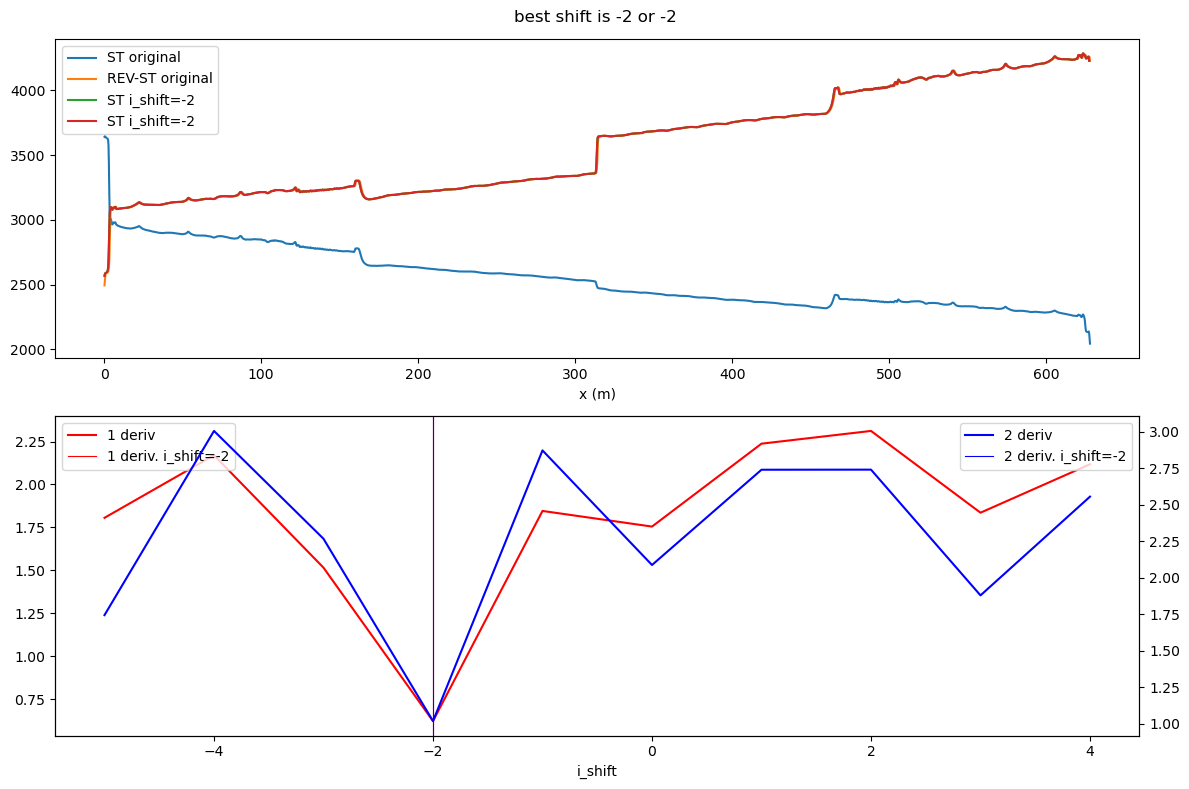

In [3]:
filepath = ''

ds_ = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds = ds_.sel(x=slice(0, 628.2))  # only calibrate parts of the fiber


sections = {
    'probe1Temperature': [slice(130., 158.)],  # temp isolator
    }
ds.sections = sections

suggested_shift = suggest_cable_shift_double_ended(
    ds,
    np.arange(-5, 5),
    plot_result=True,
    figsize=(12,8))

ds_restored = shift_double_ended(ds, suggested_shift[0])

print(ds.x, 3*'\n', ds_restored.x)

matching_sections = [
    (slice(130., 158.), slice(470.5, 498.75), False)
]
sections = {
    'probe1Temperature': [slice(130., 158.), slice(470., 500.)]
    }
ds_.sections = sections
st_var, resid = ds.variance_stokes(st_label='st')
ast_var, _ = ds.variance_stokes(st_label='ast')
rst_var, _ = ds.variance_stokes(st_label='rst')
rast_var, _ = ds.variance_stokes(st_label='rast')

ds.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    trans_att=[314.25],
    matching_sections=matching_sections,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')

ds_.calibration_double_ended(
    st_var=st_var,
    ast_var=ast_var,
    rst_var=rst_var,
    rast_var=rast_var,
    store_tmpw='tmpw',
    method='wls',
    solver='sparse')


# 1. DTS data messaging

<IPython.core.display.Javascript object>


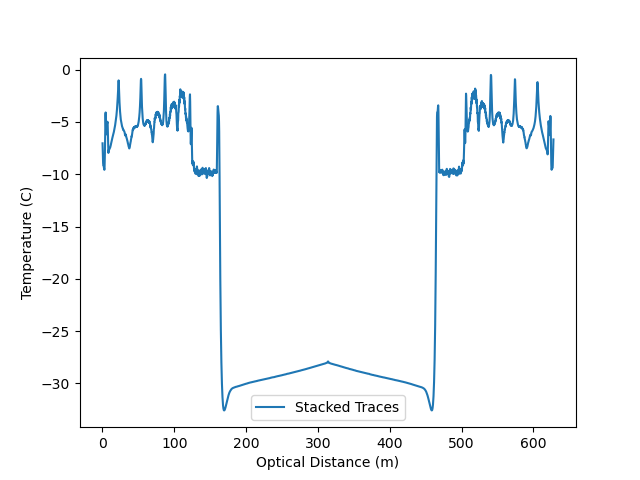

In [33]:
top_trend = 182 #optical distance (m), This is what we think the start of the long term signal is.
bottom_trend = 312.5 #optical distance (m), This is the bottom of the trend just above the warm bottom anomaly..
start_of_borehole = 162 #optical distance (m), Top of the borehole.

mean_sig1 = (ds.isel(time=0).tmpw + ds.isel(time=0).tmpw[::-1])/2
mean_sig2 = (ds.isel(time=1).tmpw + ds.isel(time=1).tmpw[::-1])/2
mean_sig3 = (ds.isel(time=2).tmpw + ds.isel(time=2).tmpw[::-1])/2

mean_tot = (mean_sig1 + mean_sig2 + mean_sig3) / 3


%matplotlib notebook

fig, ax = plt.subplots()
#plt.style.use('dark_background')
ax.plot(ds.x, mean_tot, label = 'Stacked Traces')
#ax.plot(ds.x, mean_tot[::-1], label = 'mean reversed')

ax.set_ylabel('Temperature (C)')
ax.set_xlabel('Optical Distance (m)')
# plt.xlim([top_trend, bottom_trend])
# plt.ylim([-31,-28])
plt.legend()

<IPython.core.display.Javascript object>


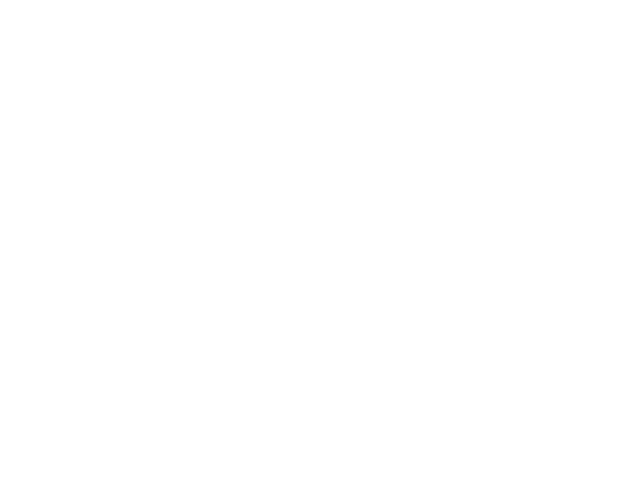

In [5]:
borehole_below_season = mean_tot.sel(x=slice(top_trend,bottom_trend))

%matplotlib notebook

fig, ax = plt.subplots()
plt.gca().invert_yaxis()
#plt.style.use('dark_background')
ax.plot(mean_tot, ds.x - start_of_borehole, label = 'Stacked Traces')
#ax.plot(ds.x, mean_tot[::-1], label = 'mean reversed')

ax.set_xlabel('Temperature (C)')
ax.set_ylabel('Depth (m)')
ax.set_ylim([150, 0])
plt.xlim([-34,-15])
plt.show()
#plt.legend()

## 1.1 We remove the linear fit from the signal which should leave just the climate variations.

43.486313968691086
-33.536878835630226


<IPython.core.display.Javascript object>


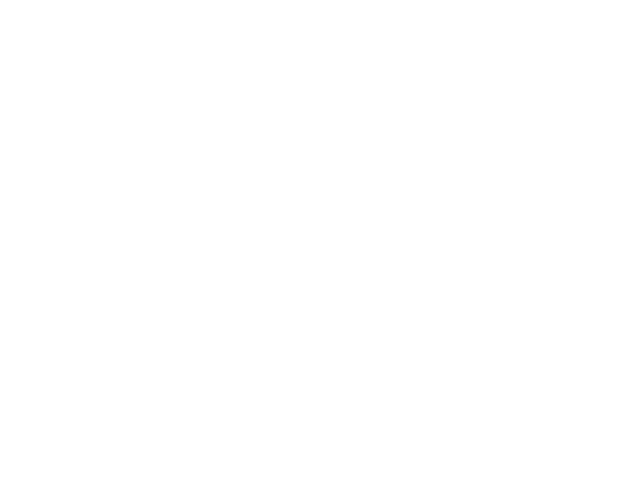

In [6]:
#Geothermal flux from a linear fit

#Where do we want to start the linear best fit relatively to the top of what we think the trend is?

start_here = 0   # 0 is the start of the top of the trend

m,b = np.polyfit(mean_tot.sel(x=slice(top_trend+start_here,bottom_trend)).x, 
                 mean_tot.sel(x=slice(top_trend+start_here,bottom_trend)), 1)

Q_geo = m *2.5*1e3
print(Q_geo)
print(b)

x  = m*mean_tot.sel(x=slice(top_trend+start_here,bottom_trend)).x + b

y  = m*mean_tot.sel(x=slice(top_trend,bottom_trend)).x + b
anomaly = mean_tot.sel(x=slice(top_trend,bottom_trend)) - y

#plot the geothermal heat flux
%matplotlib notebook

fig, ax = plt.subplots()
plt.gca().invert_yaxis()
#plt.style.use('dark_background')
ax.plot(mean_tot, ds.x - start_of_borehole, label = 'DTS - Temp Profile', lw = 3, c='steelblue')
ax.plot(x, mean_tot.sel(x=slice(top_trend+start_here,bottom_trend)).x - start_of_borehole, label = 'Line of Best Fit', ls="--", lw = 3, c='red')
#ax.plot(ds.x, mean_tot[::-1], label = 'mean reversed')

ax.set_xlabel('Temperature (C)')
ax.set_ylabel('Depth (m)')
ax.set_ylim([150, 0])
ax.set_xlim([-31,-27])
plt.legend()

## 1.2 Use detrend to remove the linear fit and plot.

<IPython.core.display.Javascript object>


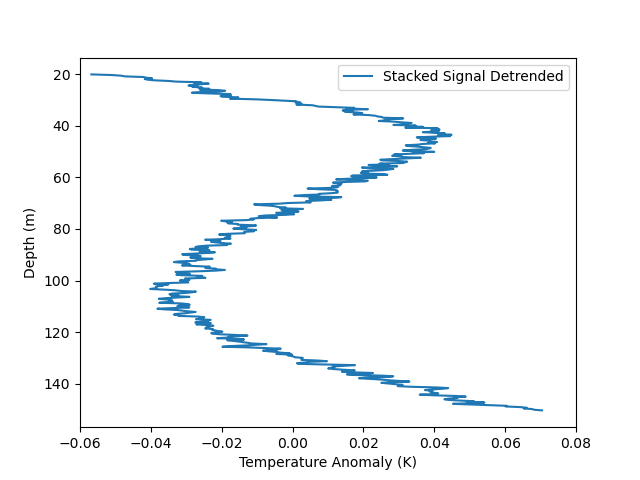

In [7]:
import scipy

detrend = scipy.signal.detrend(mean_tot.sel(x=slice(top_trend,bottom_trend)), type='linear', bp=0, overwrite_data=False)

%matplotlib notebook

fig, ax = plt.subplots()
#plt.style.use('dark_background')
ax.plot( detrend, borehole_below_season.x - start_of_borehole, label = 'Stacked Signal Detrended')


ax.set_xlabel('Temperature Anomaly (K)')
ax.set_ylabel('Depth (m)')


ax.invert_yaxis()
ax.set_xlim([-.06,0.08])
plt.legend()

# 2.0 Now, set up the forward model of borehole temps

In [9]:
from heat import *

import numpy as np

#Parameters

tmax = 2023
tmin = 1023
zmax = bottom_trend - top_trend#150
dTdz = 0.02
nz = len(mean_tot.sel(x=slice(top_trend,bottom_trend)))
nt = 99
alpha = 35
accumulation = 0

t_surf = np.eye(nt)

A = np.zeros((nt+1,nz+1))

for i in range(nt): #this was for i in range(nt)
    this_t_surf = t_surf[i,:]
#     if i == 20: this_t_surf = 10*this_t_surf
    U,t,z = heat(this_t_surf,
         tmax = tmax,
         tmin = tmin,
         zmax = zmax,
         dTdz = dTdz,
         nz = nz,
         nt = nt,
         alpha = alpha,
         accumulation = accumulation)
    now = U[:,-1]
    A[i,:] = now
A = A.T
#     print(z.shape)
#     heat_plot(t, t_surf, 0, 1000, z, U)

In [34]:
nz

513

<IPython.core.display.Javascript object>


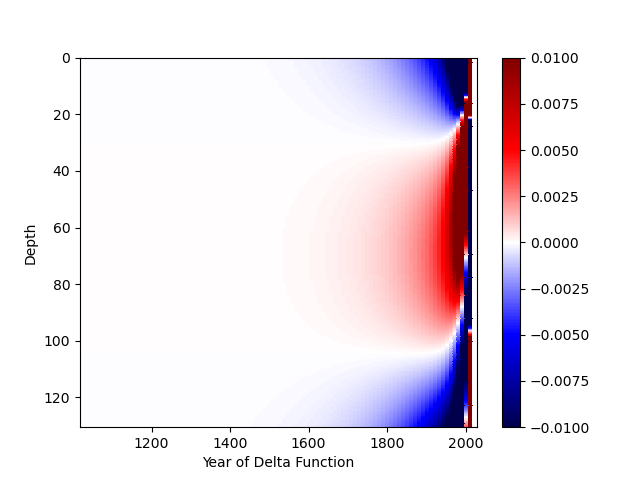

In [10]:
from scipy.signal import detrend
plt.subplots()
vm=0.01
c=plt.pcolor(t,z,detrend(A,axis=0),vmin=-vm,vmax=vm,cmap='seismic')
# c=plt.pcolor(t,z,A,vmin=-vm,vmax=vm,cmap='seismic')
plt.colorbar(c)
plt.ylim([zmax,0])
plt.xlabel('Year of Delta Function')
plt.ylabel('Depth')
plt.show()

# 3.0 Set up the inverse problem

## 3.1 The G matrix is the forward modeled borehole temps

<IPython.core.display.Javascript object>


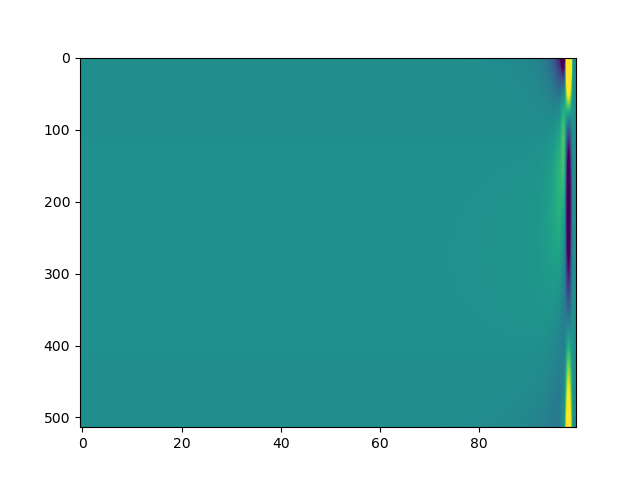

In [11]:
G_matrix = detrend(A,axis=0)

fig, ax = plt.subplots()
ax.imshow(G_matrix, aspect = 'auto', vmin=-.1, vmax=.1)
plt.show()

G_copy = G_matrix

## 3.2 Singular value threshold, plot the singular values

<IPython.core.display.Javascript object>


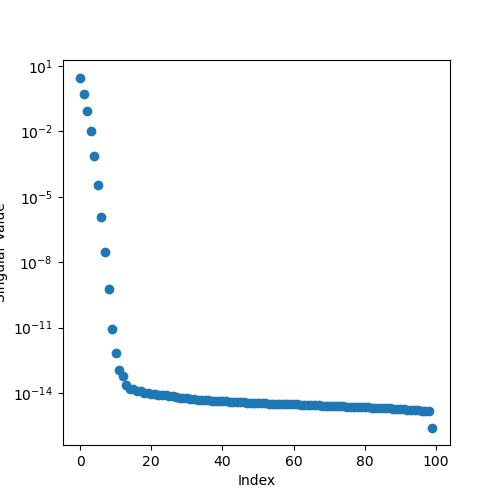

In [12]:
#Singular value decomposition
u, s, v_T = np.linalg.svd(G_copy, full_matrices=True)


#Plotting the singular values
fig,ax = plt.subplots(figsize=[5,5])
plt.scatter(np.arange(0,len(s)),s)
ax.set_xlabel('Index')
ax.set_ylabel('Singular Value')
ax.set_yscale('log')
#ax.set_xlim([0,10])
# print(s)
#fig.savefig('singular_values.eps')
plt.show()

## 3.3 Apply the thresholding

In [13]:


p = 4 #Applying the thresholding
u_p = u[:,:p]
s_p = np.diag(s[:p])
vh_p = v_T.T[:,:p]

# print('U_p =\n', u_p)
# print('S_p =\n',s_p)
# print('V_p =\n',vh_p)

## 3.4 Find the generalized G matrix and inverse G matrix

In [14]:
#Now finding the generalized G matrix

g_gen = u_p @ s_p @ vh_p.T
# print('G = \n', g_gen)

#And the inverse Gen G matrix

u_p_transpose = u_p.T
s_p_inv = np.linalg.inv(s_p)

g_inv = vh_p @ s_p_inv @ u_p_transpose

# print('G^-g = \n', g_inv)

# 4.0 Now, we are removing the trend/geothermal flux to just get the temperature variations due to surface temp changes.

<IPython.core.display.Javascript object>


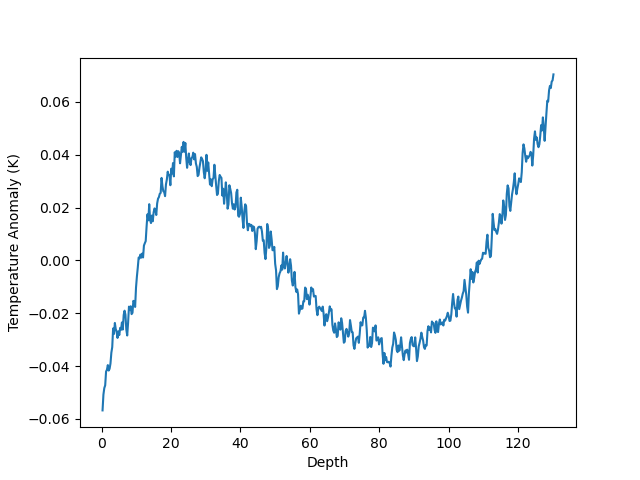

Text(0.5, 0, 'Depth')

In [15]:
#remove geo_flux in our data to get the temperature anomaly

anomaly = mean_tot.sel(x=slice(top_trend,bottom_trend)) - y

#Resample to the shape of z defined above
# anomaly_resamp = np.interp(z, anomaly.x.values-top_trend, anomaly.values)

fig,ax = plt.subplots()
#ax.plot(anomaly.values)
ax.plot(z[:-1],anomaly)
ax.set_ylabel('Temperature Anomaly (K)')
ax.set_xlabel('Depth')

# 5.0 Inversion and model estimates done here.

## 5.1 Model estimates: temperature reconstruction

<IPython.core.display.Javascript object>


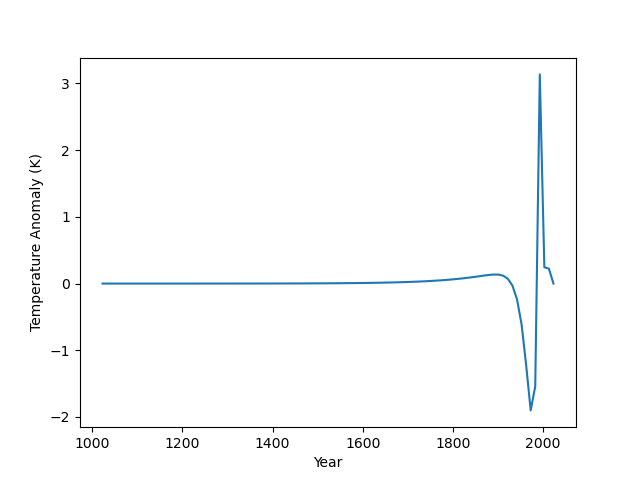

Text(0.5, 0, 'Year')

In [16]:
#model estimates
#m_est = g_inv @ anomaly.values
m_est = g_inv[:,:-1] @ anomaly.values

# m_est = g_inv[:,:-1] @ mean_tot.sel(x=slice(start_of_borehole,bottom_trend)).values

fig,ax = plt.subplots()
ax.plot(t,m_est)
ax.set_ylabel('Temperature Anomaly (K)')
ax.set_xlabel('Year')

## 5.2 Predicted data

<IPython.core.display.Javascript object>


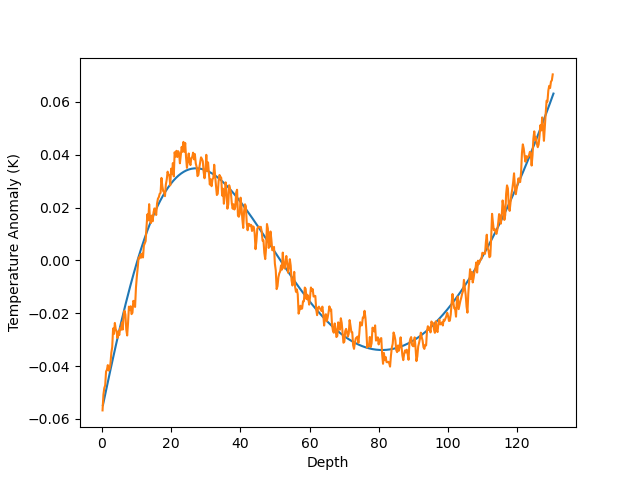

Text(0.5, 0, 'Depth')

In [17]:
#Predicted data
d_predicted = G_copy @ m_est

fig,ax = plt.subplots()
ax.plot(z,d_predicted, label='Predicted Data')
ax.plot(anomaly.x - top_trend, anomaly.values, label='Actual Data')
ax.set_ylabel('Temperature Anomaly (K)')
ax.set_xlabel('Depth')

## 5.3 Model resolution, covariances and other matrices

<IPython.core.display.Javascript object>


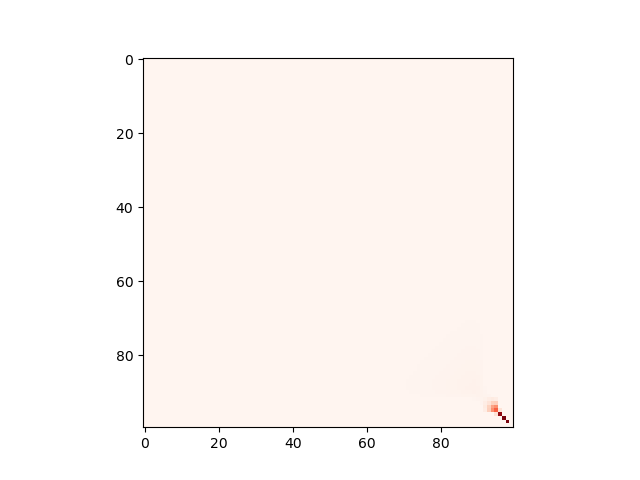

In [18]:
R_model = g_inv @ g_gen

fig,ax = plt.subplots()
ax.imshow(R_model,vmin=0,vmax=1,cmap='Reds')
#ax.imshow(np.log10(np.abs(R_model)))

<IPython.core.display.Javascript object>


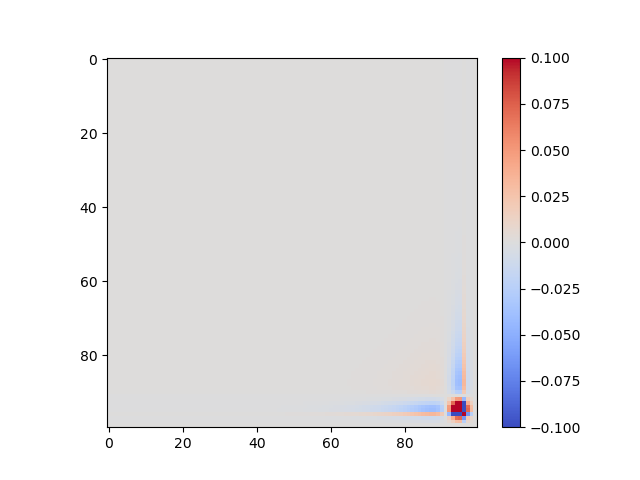

In [19]:
sigma_obs = 0.01
cov_m = sigma_obs**2 * g_inv @ g_inv.T

fig, ax= plt.subplots()
im = ax.imshow(cov_m,cmap='coolwarm',vmin=-0.1,vmax=.1)
plt.colorbar(im)

## 5.4 Thresholding testing

<IPython.core.display.Javascript object>


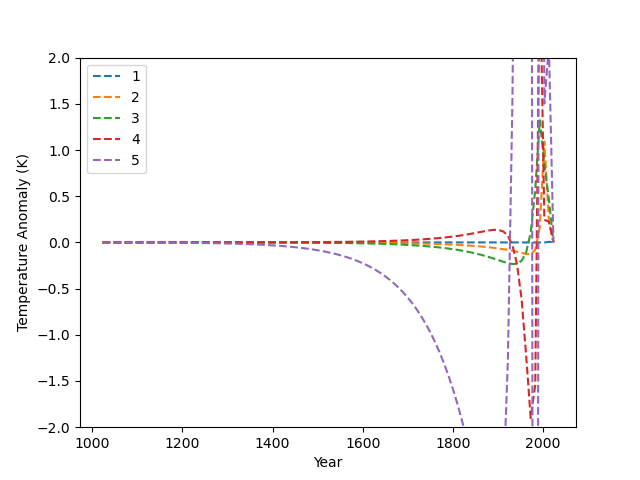

In [20]:
fig, ax = plt.subplots()

ax.set_ylabel('Temperature Anomaly (K)')
ax.set_xlabel('Year')
ax.set_ylim([-2,2])

for i in np.arange(1,6,1):
    
    p = i #Applying the thresholding
    u_p = u[:,:p]
    s_p = np.diag(s[:p])
    vh_p = v_T.T[:,:p]
    
    #Now finding the generalized G matrix

    g_gen = u_p @ s_p @ vh_p.T
    # print('G = \n', g_gen)

    #And the inverse Gen G matrix

    u_p_transpose = u_p.T
    s_p_inv = np.linalg.inv(s_p)

    g_inv = vh_p @ s_p_inv @ u_p_transpose

    # print('G^-g = \n', g_inv)
    
    m_est = g_inv[:,:-1] @ anomaly.values
    
    ax.plot(t,m_est, ls='--', label = str(i))
plt.legend()

# 6.0 Monte Carlo modeling. 

## We improve each time, and then we save the imporved run and do that n amount of times starting from scratch each time

## These are called "Monte Carlo Restarts"

In [25]:
### First we have to re-initialize because of the thresholding testing we did above ###



p = 4 #Applying the thresholding
u_p = u[:,:p]
s_p = np.diag(s[:p])
vh_p = v_T.T[:,:p]

# print('U_p =\n', u_p)
# print('S_p =\n',s_p)
# print('V_p =\n',vh_p)

#Now finding the generalized G matrix

g_gen = u_p @ s_p @ vh_p.T
# print('G = \n', g_gen)

#And the inverse Gen G matrix

u_p_transpose = u_p.T
s_p_inv = np.linalg.inv(s_p)

g_inv = vh_p @ s_p_inv @ u_p_transpose

# print('G^-g = \n', g_inv)

#model estimates
#m_est = g_inv @ anomaly.values
m_est = g_inv[:,:-1] @ anomaly.values

In [26]:
import copy
from tqdm import tqdm

# 1) guess m_i (we have a good guess right now, the first m_est we calculated). This will be the first iteration of the MC
m_est = g_inv[:,:-1] @ anomaly.values

d_pred_i = G_copy @ m_est
d_obs = anomaly.values
#r_i = (1 / (np.sqrt(2*np.pi) * sigma)) * np.exp(-(sum((d_obs - d_pred_i[:-1])**2))**2 / 2*(sigma**2))
r_i = sum(np.abs(d_pred_i[:-1] - d_obs))
m_accepted_all = [m_est]
m_not_accepted = []
predicted_data = []
r_values = [r_i]
sigma = 0.01 #st dev of temperature measurement

iterations = 500
restarts = 100
best_of_restart = []
for j in tqdm(range(restarts)):
    m_accepted = [m_est]
    for i in range(iterations):

        # 1) guess m_i (we have a good guess right now, the first m_est we calculated). This will be the first iteration of the MC
        m_est = g_inv[:,:-1] @ anomaly.values
    #     m_i = m_est
    #     m_accepted = [m_i]
    #     d_pred_i = G_copy @ m_i
    #     d_obs = anomaly.values
        #r_i = (1 / (np.sqrt(2*np.pi) * sigma)) * np.exp(-(sum((d_obs - d_pred_i[:-1])**2))**2 / 2*(sigma**2))
    #     r_i = sum(np.abs(d_pred_i[:-1] - d_obs))

        #year_change = np.random.randint(0,m_i.shape[0]) #randomly select a year to change
    #     m_next = m_accepted[-1] #set the temp history as the most recent one to be accepted

        m_next_copy = copy.deepcopy(m_accepted[-1])
        change =  np.random.normal(loc=0,scale=.1, size = m_next_copy.shape) #change that year's temperature according to a random gaussian walk 

        m_next_copy = m_next_copy + change
        #Predicted data
        d_pred = G_copy @ m_next_copy

        # 2) r = (1 / (sqrt(2*pi) * sigma)) * exp(-(sum((d_obs - d_pred)**2))**2 / 2*(sigma**2) sigma = 0.01

        r = sum(np.abs(d_pred[:-1] - d_obs))
        #print(r)
        sigma = 1 * np.sqrt(len(m_next_copy))
        #print(sigma)
        L = np.exp(-r**2/sigma**2 / 2) / np.sqrt(2*np.pi) / sigma 
        #print(L)
        #r = (1 / (np.sqrt(2*np.pi) * sigma)) * np.exp(-(sum((d_obs - d_pred[:-1])**2))**2 / 2*(sigma**2))
        #print('r = ' + str(r)+ ', and r_0 = ' + str(r_i))
        alpha = np.random.rand()
        #print(alpha)

        ### Do this to always improve ###

        if L > alpha:
            r_values.append(r)
            m_accepted_all.append(m_next_copy)
            predicted_data.append(d_pred)
            m_accepted.append(m_next_copy)
            #print('r = ' + str(r))
#             print('L = '+ str(L)+'  , alpha = '+str(alpha))
#             print("accepted")
        if L < alpha:
            m_not_accepted.append(m_next_copy)
    best_of_restart.append(np.asarray(m_accepted[-1]).T)
#     ### Do this to always to always keep performers that beat the SVD ###
    
#     if r < r_i:
#         r_values.append(r)
#         m_accepted.append(m_next_copy)
#         predicted_data.append(d_pred)
#         print('r = ' + str(r))
#     if r > r_i:
#         m_not_accepted.append(m_next_copy)

# fig, ax= plt.subplots()
# ax.plot(m_est)
# ax.plot(np.asarray(m_accepted).T)

# fig, ax= plt.subplots()
# ax.plot(m_est)
# ax.plot(np.asarray(m_not_accepted).T)

100%|██████████| 100/100 [1:04:49<00:00, 38.89s/it]


In [27]:
std_all = np.std(np.asarray(m_accepted_all).T, axis=1)
mean_all = np.mean(np.asarray(m_accepted_all).T, axis=1)

<IPython.core.display.Javascript object>


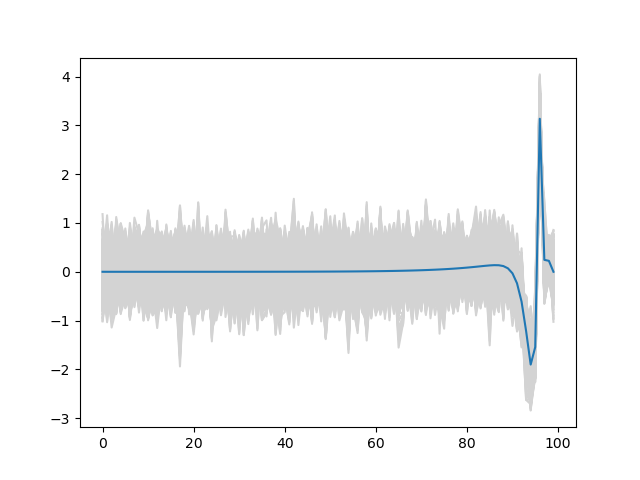

<IPython.core.display.Javascript object>


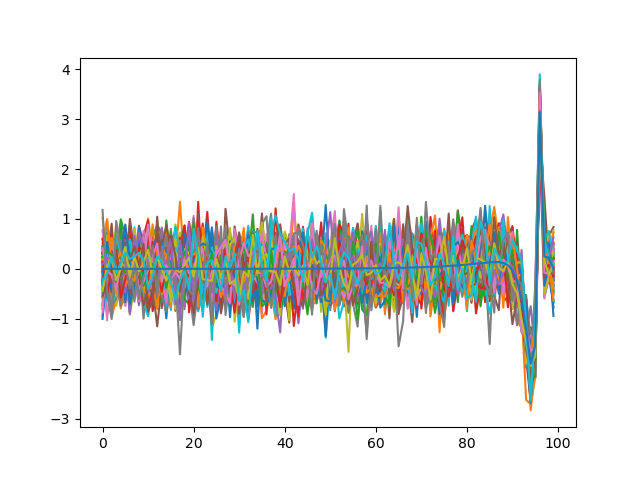

<IPython.core.display.Javascript object>


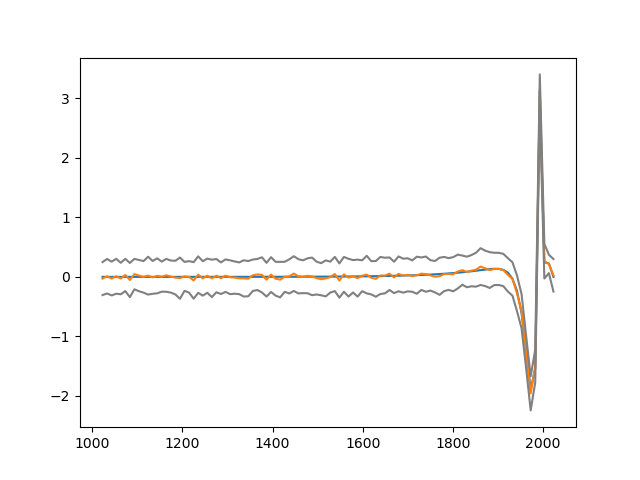

<IPython.core.display.Javascript object>


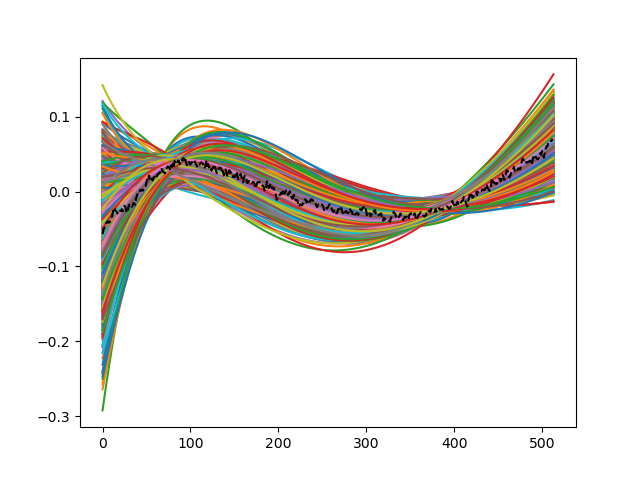

In [29]:
fig, ax= plt.subplots()

ax.plot(np.asarray(m_accepted_all).T, color='lightgrey')
ax.plot(m_est)

fig, ax= plt.subplots()
ax.plot(np.asarray(best_of_restart).T)
ax.plot(m_est)

fig, ax= plt.subplots()
ax.plot(t,m_est)
ax.plot(t,mean_all)
ax.plot(t,mean_all+std_all, color = 'grey')
ax.plot(t,mean_all-std_all, color = 'grey')

fig, ax= plt.subplots()
ax.plot(np.asarray(predicted_data).T)
ax.plot(d_obs, ls='--', c='black')
plt.show()

<IPython.core.display.Javascript object>


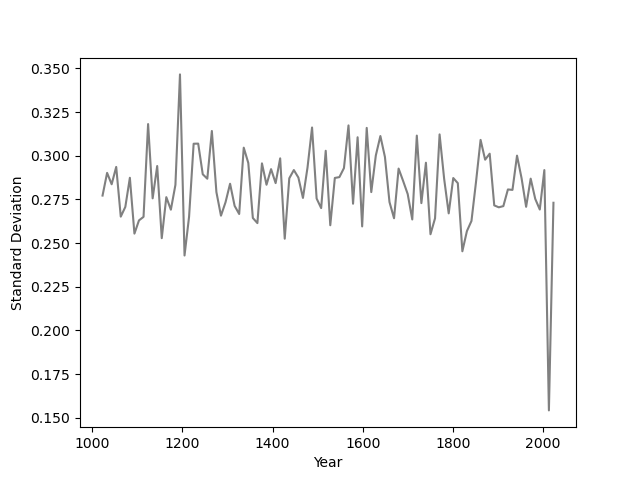

Text(0.5, 0, 'Year')

In [40]:
fig, ax= plt.subplots()

ax.plot(t,std_all, color = 'grey')
ax.set_ylabel('Standard Deviation')
ax.set_xlabel('Year')

# AWS validation

In [ ]:
import glob
import pandas as pd
dates_therm = []
temps_therm = []

for i in sorted(glob.glob('AWS_temp/*')):
    data = pd.read_csv(i, sep='\t')
    data.interpolate()
    for j in data.iloc():
        dates_therm.append(datetime.strptime(j['DateTime UTC    '],'%Y-%m-%d %H:%M'))
        if j['Temp'] == 'Null':
            
            temps_therm.append(np.nan)
        else:
            temps_therm.append(float(j['Temp']))


In [ ]:
temps_therm

In [ ]:
fig, ax= plt.subplots()
ax.plot(t,m_est)
ax.plot(t,mean_all)
ax.plot(t,mean_all+std_all, color = 'grey')
ax.plot(t,mean_all-std_all, color = 'grey')

fig, ax= plt.subplots()


temps_therm = pd.DataFrame(temps_therm).interpolate().values
datelist = pd.date_range(datetime(1923,1,1), periods=100, freq='Y').tolist()
temps_detrend = temps_therm - np.mean(temps_therm)

ax.plot(dates_therm,temps_therm)
fig, ax= plt.subplots()
ax.plot(dates_therm,temps_detrend)

ax.plot(datelist,m_est)
ax.plot(datelist,mean_all)
ax.plot(datelist,mean_all+std_all, color = 'grey')
ax.plot(datelist,mean_all-std_all, color = 'grey')